In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [25]:
epochs = 1
model_name = 'bert-base'

In [3]:
import pandas as pd
import numpy as np
import json

In [4]:
data_path = '/home/Danny/Data-Mining/lab2/kaggle/data/'

In [5]:
json_list = list()
with open(data_path + 'tweets_DM.json' , 'r') as file:
    for line in file:
        json_list.append(json.loads(line))

In [6]:
tweet_list = list()
for json in json_list:
    tweet_id = json['_source']['tweet']['tweet_id']
    hashtags = json['_source']['tweet']['hashtags']
    hashtag = ' '.join(hashtags)
    text = json['_source']['tweet']['text']
    text = text + ' ' + hashtag
    tweet_list.append([tweet_id, text])

In [7]:
emotion_df = pd.read_csv(data_path + 'emotion.csv')
emotion_df

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [8]:
identification_df = pd.read_csv(data_path + 'data_identification.csv')
identification_df

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [9]:
emoji_dict = {
    "😂": "lolface",
    "😂😂": "lolface",
    "😂😂😂": "lolface",
    "😇": "smile",
    "😀": "smile",
    "🎉": "party",
    "😳": "embarrassed",
    "😔": "sadface",
    "👀": "shifty",
    "🤷": "shrugging",
    "💔": "brokenhearted",
    "👻": "ghost",
    "😍": "heart",
    "🙄": "disdain",
    "💖": "heart",
    "✌": "victory",
    "🎶": "music",
    "😱": "shock",
    "😃": "smile",
    "😒": "unsatisfied",
    "👊": "brofist",
    "😄": "smile",
    "🌞": "smile",
    "🙌": "celebration",
    "😁": "smile",
    "🤗": "hugging",
    "🤣": "rofl",
    "🌈": "gaypride",
    "😉": "winking",
    "💞": "heart",
    "🙃": "irony",
    "😜": "winking",
    "😭": "bawling",
    "🤔": "thinker",
    "😎": "cool",
    "💛": "heart",
    "💚": "heart",
    "💃": "fun",
    "💗": "heart",
    "😬": "awkward",
    "😌": "relieved",
    "😅": "whew",
    "💋": "kiss",
    "🙈": "laugh",
    "😊": "^^",
    "👌": "okay",
    "😡": "angry",
    "😘": "kiss",
    "😩": "weary",
    "🔥": "excellent",
    "💙": "heart",
    "💕": "heart",
    "👏": "clapping",
    "👍": "thumbsup",
    "💯": "perfect",
    "💜": "heart",
    "🕘" : "late",
    "😡" : "angry",
    "😒" : "dissatisfied",
    "😤" : "angry",
    "😠" : "angry",
    "😑" : "annoy",
    "😡😡😡" : "angry",
    "😡😡" : "angry",
    "😰": "anxious",
    "😯": "surprise",
    "😨": "scared",
    "😲": "astonished",
    "💪": "strong",
    "🤦": "facepalm",
    "✨": "sparkle",
    "😢": "crying",
    "💓": "heart",
    "👑": "crown",
    "🤘": "rockon",
    "🌹": "rose",
    "😋": "delicious",
    "😏": "flirting",
    "😆": "XD",
    "😫": "exhausted",
    "😦": "frowning",
    "🙏": "please",
}

In [10]:
frequent_name_dict = {
    "#realdonaldtrump": "sadness",
    "#fifthharmony": "sadness",
    "#mostrequestlive": "sadness",
    "#onairromeo": "sadness",
    "#matthardybrand": "sadness",
}

In [11]:
def replace_word(text):
    text_list = text.split()
    for i, j in enumerate(text_list):
        if j in emoji_dict:
            text_list[i] = emoji_dict[j]
        if j in frequent_name_dict:
            text_list[i] = frequent_name_dict[j]
    return ' '.join(text_list)

In [12]:
text_df = pd.DataFrame(tweet_list, columns=['tweet_id', 'text'])
text_df

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [13]:
%%time
import re
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
text_df['text'] = text_df['text'].apply(lambda s : s.lower())
text_df['text'] = text_df['text'].apply(lambda s : replace_word(s))    
text_df['text'] = text_df['text'].apply(lambda s : re.sub('<lh>|<|>|@|#', '', s))
# text_df['text'] = text_df['text'].apply(lambda s : s.replace('<lh>',''))
# text_df['text'] = text_df['text'].apply(lambda s : s.replace('#',''))
# text_df['text'] = text_df['text'].apply(lambda s : s.replace('@',''))
text_df['token'] = text_df['text'].apply(lambda s : tweet_tokenizer.tokenize(s)) 
text_df

CPU times: user 2min 11s, sys: 8.88 s, total: 2min 19s
Wall time: 2min 22s


,tweet_id,text,token
0,0x376b20,"people who post ""add me on snapchat"" must be d...","[people, who, post, "", add, me, on, snapchat, ..."
1,0x2d5350,"brianklaas as we see, trump is dangerous to fr...","[brianklaas, as, we, see, ,, trump, is, danger..."
2,0x28b412,"confident of your obedience, i write to you, k...","[confident, of, your, obedience, ,, i, write, ..."
3,0x1cd5b0,now issa is stalking tasha lolface,"[now, issa, is, stalking, tasha, lolface]"
4,0x2de201,"""trust is not the same as faith. a friend is s...","["", trust, is, not, the, same, as, faith, ., a..."
...,...,...,...
1867530,0x316b80,when you buy the last 2 tickets remaining for ...,"[when, you, buy, the, last, 2, tickets, remain..."
1867531,0x29d0cb,i swear all this hard work gone pay off one da...,"[i, swear, all, this, hard, work, gone, pay, o..."
1867532,0x2a6a4f,parcel2go no card left when i wasn't in so i h...,"[parcel, 2go, no, card, left, when, i, wasn't,..."
1867533,0x24faed,"ah, corporate life, where you can date using ...","[ah, ,, corporate, life, ,, where, you, can, d..."


In [14]:
test_df = identification_df[identification_df['identification'] == 'test']
# test_df

In [15]:
train_df = text_df.merge(emotion_df, left_on='tweet_id', right_on='tweet_id')
# train_df

In [16]:
x_list = train_df['token'].to_list()
y_list = train_df['emotion'].to_list()
print(len(x_list))
print(len(y_list))

1455563
1455563


In [17]:
# x_list_list = list()
# for x in x_list:
#     x_list_list.append(x.split())
# len(x_list_list)

In [18]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x_list, y_list, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))
print(len(valid_x), len(valid_y))

931560 931560
291113 291113
232890 232890


In [26]:
%%time
import kashgari
from kashgari.tasks.classification import BiLSTM_Model
kashgari.config.use_cudnn_cell = True
import logging
logging.basicConfig(level='DEBUG')
from kashgari.embeddings import BertEmbedding
bert_embed = BertEmbedding('/home/Danny/pretrain_model/{}'.format(model_name))
model = BiLSTM_Model(bert_embed, sequence_length='auto')
model = BiLSTM_Model()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(train_x, 
                    train_y, 
                    valid_x, 
                    valid_y,
                    epochs=epochs,
         )

2020-12-01 17:18:42,617 [DEBUG] kashgari - ------------------------------------------------
2020-12-01 17:18:42,618 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-01 17:18:42,618 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-base/bert_config.json
2020-12-01 17:18:42,618 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-base/vocab.txt
2020-12-01 17:18:42,618 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-base/bert_model.ckpt
2020-12-01 17:18:42,619 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]'

14555/14555 [==============================] - 1347s 93ms/step - loss: 1.1984 - accuracy: 0.5678 - val_loss: 1.1215 - val_accuracy: 0.5960
CPU times: user 3h 41min 45s, sys: 19min 23s, total: 4h 1min 9s
Wall time: 22min 40s


In [27]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
model.save(model_path)

2020-12-01 17:41:22,767 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 102
2020-12-01 17:41:28,119 [DEBUG] kashgari - predict input shape (291113, 102) x: 
[[   2  109   11 ...    0    0    0]
 [   2  172   80 ...    0    0    0]
 [   2  806   56 ...    0    0    0]
 ...
 [   2    9 1616 ...    0    0    0]
 [   2   12  344 ...    0    0    0]
 [   2  976 5113 ...    0    0    0]]
2020-12-01 17:42:02,964 [DEBUG] kashgari - predict output shape (291113, 8)
2020-12-01 17:42:03,093 [DEBUG] kashgari - predict output argmax: [0 2 0 ... 3 0 0]


              precision    recall  f1-score   support

       anger     0.6529    0.2722    0.3842      7946
anticipation     0.6598    0.6064    0.6320     49984
     disgust     0.4795    0.4789    0.4792     27669
        fear     0.6450    0.4664    0.5413     12846
         joy     0.6027    0.8126    0.6921    102943
     sadness     0.5322    0.5342    0.5332     38745
    surprise     0.7056    0.2647    0.3849      9816
       trust     0.6531    0.3740    0.4756     41164

    accuracy                         0.5979    291113
   macro avg     0.6164    0.4762    0.5153    291113
weighted avg     0.6053    0.5979    0.5844    291113



2020-12-01 17:42:08,737 [INFO] kashgari - model saved to /home/Danny/Data-Mining/lab2/kaggle/kashgari/model/bert-base_epoch_1


'/home/Danny/Data-Mining/lab2/kaggle/kashgari/model/bert-base_epoch_1'

In [28]:
from matplotlib import pyplot as plt

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Uroob' (Uroob.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sco

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manag

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-RI.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gargi' (Gargi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Vemana2000' (vemana2000.ttf) normal norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Uroob' (Uroob.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplot

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sawasdee' (Sawasdee-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstLetter' (KacstLetter.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Purisa' (Purisa-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'N

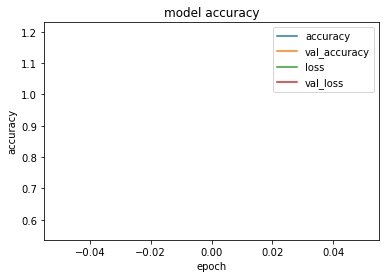

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [30]:
# model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
# model = kashgari.utils.load_model(model_path)
# model.evaluate(test_x, test_y)

In [31]:
test_df = test_df.merge(text_df, left_on='tweet_id', right_on='tweet_id')
test_df

,tweet_id,identification,text,token
0,0x28cc61,test,habbo i've seen two separate colours of the el...,"[habbo, i've, seen, two, separate, colours, of..."
1,0x2db41f,test,foxnews kellyannepolls no serious self respect...,"[foxnews, kellyannepolls, no, serious, self, r..."
2,0x2466f6,test,"looking for a new car, and it says 1 lady owne...","[looking, for, a, new, car, ,, and, it, says, ..."
3,0x23f9e9,test,cineworld “only the brave” just out and founta...,"[cineworld, “, only, the, brave, ”, just, out,..."
4,0x1fb4e1,test,felt like total dog 💩 going into open gym and ...,"[felt, like, total, dog, 💩, going, into, open,..."
...,...,...,...,...
411967,0x2c4dc2,test,6 year old walks in astounded. mum! look how b...,"[6, year, old, walks, in, astounded, ., mum, !..."
411968,0x31be7c,test,only one week to go until the inspiringvolunte...,"[only, one, week, to, go, until, the, inspirin..."
411969,0x1ca58e,test,"i just got caught up with the manga for ""my he...","[i, just, got, caught, up, with, the, manga, f..."
411970,0x35c8ba,test,speak only when spoken to and make hot ass music,"[speak, only, when, spoken, to, and, make, hot..."


In [32]:
text_list = list()
for text in test_df['text'].tolist():
    text_list.append(text.split())
text_list

[['habbo',
  "i've",
  'seen',
  'two',
  'separate',
  'colours',
  'of',
  'the',
  'elegant',
  'furni',
  'on',
  'your',
  'homepage?'],
 ['foxnews',
  'kellyannepolls',
  'no',
  'serious',
  'self',
  'respecting',
  'individual',
  'believes',
  'much',
  'less',
  'agrees',
  'w',
  'her'],
 ['looking',
  'for',
  'a',
  'new',
  'car,',
  'and',
  'it',
  'says',
  '1',
  'lady',
  'owner.',
  'that',
  'means',
  'needs',
  'new',
  'clutch,',
  'gearbox',
  'and',
  'brakes.',
  'womendrivers',
  'womendrivers'],
 ['cineworld',
  '“only',
  'the',
  'brave”',
  'just',
  'out',
  'and',
  'fountain',
  'park',
  'have',
  'only',
  '3',
  'showings',
  'per',
  'day!',
  'robbingmembers',
  'robbingmembers'],
 ['felt',
  'like',
  'total',
  'dog',
  '💩',
  'going',
  'into',
  'open',
  'gym',
  'and',
  'had',
  'a',
  'migraine',
  'played',
  'through',
  'and',
  'sweated',
  'it',
  'out',
  'and',
  'my',
  'sweat',
  'has',
  'never',
  'been',
  'that',
  'bad.'],


In [33]:
predict_list = model.predict(text_list)
predict_list

2020-12-01 17:42:14,508 [DEBUG] kashgari - predict input shape (411972, 62) x: 
[[    2 52199   244 ...     0     0     0]
 [    2   812  4492 ...     0     0     0]
 [    2   280    13 ...     0     0     0]
 ...
 [    2     9    38 ...     0     0     0]
 [    2   774    78 ...     0     0     0]
 [    2    85    43 ...     0     0     0]]
2020-12-01 17:42:59,615 [DEBUG] kashgari - predict output shape (411972, 8)
2020-12-01 17:42:59,769 [DEBUG] kashgari - predict output argmax: [0 3 0 ... 1 0 3]


['joy',
 'sadness',
 'joy',
 'sadness',
 'disgust',
 'anticipation',
 'trust',
 'joy',
 'anticipation',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'trust',
 'joy',
 'joy',
 'disgust',
 'joy',
 'joy',
 'joy',
 'disgust',
 'joy',
 'disgust',
 'joy',
 'joy',
 'joy',
 'disgust',
 'disgust',
 'sadness',
 'sadness',
 'sadness',
 'joy',
 'joy',
 'trust',
 'disgust',
 'joy',
 'anticipation',
 'trust',
 'disgust',
 'joy',
 'anticipation',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'joy',
 'anticipation',
 'anticipation',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'surprise',
 'disgust',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'trust',
 'disgust',
 'joy',
 'disgust',
 'trust',
 'joy',
 'sadness',
 'joy',
 'joy',
 'joy',
 'joy',
 'anticipation',
 'sadness',
 'joy',
 'sadness',
 'joy',
 'sadness',
 'joy',
 'joy',
 'disgust',
 'sadness',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'joy',
 'joy',
 'disgust',
 'disgust',


In [34]:
test_df['predict'] = predict_list
test_df

,tweet_id,identification,text,token,predict
0,0x28cc61,test,habbo i've seen two separate colours of the el...,"[habbo, i've, seen, two, separate, colours, of...",joy
1,0x2db41f,test,foxnews kellyannepolls no serious self respect...,"[foxnews, kellyannepolls, no, serious, self, r...",sadness
2,0x2466f6,test,"looking for a new car, and it says 1 lady owne...","[looking, for, a, new, car, ,, and, it, says, ...",joy
3,0x23f9e9,test,cineworld “only the brave” just out and founta...,"[cineworld, “, only, the, brave, ”, just, out,...",sadness
4,0x1fb4e1,test,felt like total dog 💩 going into open gym and ...,"[felt, like, total, dog, 💩, going, into, open,...",disgust
...,...,...,...,...,...
411967,0x2c4dc2,test,6 year old walks in astounded. mum! look how b...,"[6, year, old, walks, in, astounded, ., mum, !...",joy
411968,0x31be7c,test,only one week to go until the inspiringvolunte...,"[only, one, week, to, go, until, the, inspirin...",anticipation
411969,0x1ca58e,test,"i just got caught up with the manga for ""my he...","[i, just, got, caught, up, with, the, manga, f...",anticipation
411970,0x35c8ba,test,speak only when spoken to and make hot ass music,"[speak, only, when, spoken, to, and, make, hot...",joy


In [35]:
output_df = test_df[['tweet_id', 'predict']]
output_df = output_df.rename(columns={'tweet_id':'id', 'predict':'emotion'})
# output_df

In [36]:
output_path = 'output/{}_epoch_{}.csv'.format(model_name, epochs)
output_df.to_csv(output_path, index=False, header=True)